# MNIST Classification using Abnormality Module

<h5><center>What if one uses an alphabet as an input to the model trained only with MNIST dataset?</center></h5>

To answer the question above, I've been reading some papers. Among those papers, I encountered the paper mentioned below, and the method introduced in the paper seems to be more approachable than other papers. Therefore, with some helps from true experts, I've written these codes to implement the paper. <b>Feedbacks are always welcome.</b>

In the paper 'A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks' (https://arxiv.org/abs/1610.02136), Hendrycks and Gimpel question about the high-confidence predictions of softmaxes due to its fast-growing exponential characteristic. Although, the paper also shows that softmax prediction probabilities are working for abnormality detection, it introduces a new method for detection: an auxiliar decoder (Zhang et al., 2016).  

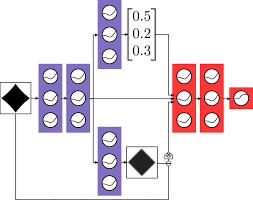</img>

<h4><center>Figure: Abnormality Module Example </center></h4>


Here's a procedure of training abnormality module using auxiliary decoder:

1. The decoder and scorer are trained jointly on in-distribution examples. 
2. The blue layers in the figure above are frozen
3. Train red layers on clean and noised training examples
4. After training we consequently have a normal classifier, an auxiliary decoder, and what we call an abnormality module. The gains from the abnormality module demonstrate there are possible research avenues for outperforming the baseline (for mode details, I'd suggest reading the paper).

With these detailed descriptions of abnormality module, here's an implemented abnormality module, originally written by Sangsu Lee (https://github.com/2sang), and modified by myself.

### 0. Importing Modules and Load Dataset

To implement the abnormality module, I use the MNIST dataset.

In [1]:
import os
import numpy as np

import keras.backend as K

import keras
from keras.layers import Input, Dense
from keras.models import Model, save_model, load_model
from noise_util import add_distortion_noise, add_distortion_blur
from noise_util import rotate90_if_not_zero

import matplotlib.pyplot as plt
import sklearn.metrics as sk
% matplotlib inline

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
##### Load MNIST dataset

mnist = keras.datasets.mnist
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = mnist.load_data()

mnist_train_x = np.reshape(mnist_train_x, [-1, 28*28]) / 255.
mnist_test_x = np.reshape(mnist_test_x, [-1, 28*28]) / 255.

### 1. Jointly Training Decoder and Scorer

Below is the process of jointly training decoder and scorer at the same time (Note: The warning "Output 'h2' missing from loss dictionary" is something has to be done in purpose; the output h2 is just a second layer output, and there's no need to train the model in order to produce better 'h2' since we're going to input h2 just the way it is to abnormality module.

In [3]:
##### Set parameters
training_epochs = 10
image_size = 28
input_dim = image_size * image_size
n_labels = 10
bottleneck_dim = 128
batch_size = 128

##### Base model
inputs = Input(shape=(input_dim, ), name='image_input')
h1 = Dense(256, activation='relu', name='h1')(inputs)
h2 = Dense(256, activation='relu', name='h2')(h1)

##### Scorer
h3 = Dense(256, activation='relu', name='h3')(h2)
logits_out = Dense(n_labels, activation='softmax', name='logits_out')(h3)

##### Decoder
bottleneck = Dense(bottleneck_dim,
                   activation='relu',
                   name='bottleneck')(h2)
decode1 = Dense(256, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(256, activation='relu', name='decode2')(decode1)
reconstruction = Dense(input_dim, name='rec_output')(decode2)

##### Instantiate base model
base_model = Model(inputs, [h2, logits_out, reconstruction], name='base')

print(base_model.summary())

base_model.compile(optimizer='adam',
                   loss={'logits_out': 'sparse_categorical_crossentropy',
                         'rec_output': 'mean_squared_error'},
                   loss_weights={'logits_out': 0.9,
                                 'rec_output': 0.1})

##### Train base model
base_model.fit(mnist_train_x,
               {'logits_out': mnist_train_y,
                'rec_output': mnist_train_x},
               validation_data = (mnist_test_x, {'logits_out': mnist_test_y, 'rec_output' : mnist_test_x}),
               epochs=training_epochs, batch_size=batch_size)

# test_loss, test_acc
test_result = base_model.evaluate(x = mnist_test_x,
                                  y = {'logits_out': mnist_test_y,'rec_output': mnist_test_x})


print("metric names:", base_model.metrics_names)


print(test_result)

# ##### SAVE MODEL
# save_model(base_model, "./mnist_aux_base.hdf5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 256)          200960      image_input[0][0]                
__________________________________________________________________________________________________
h2 (Dense)                      (None, 256)          65792       h1[0][0]                         
__________________________________________________________________________________________________
bottleneck (Dense)              (None, 128)          32896       h2[0][0]                         
__________________________________________________________________________________________________
decode1 (D

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Output "h2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "h2" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.2337 - logits_out_loss: 0.2558 - rec_output_loss: 0.0347 - val_loss: 0.1040 - val_logits_out_loss: 0.1129 - val_rec_output_loss: 0.0240
Epoch 2/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.0870 - logits_out_loss: 0.0942 - rec_output_loss: 0.0226 - val_loss: 0.0863 - val_logits_out_loss: 0.0935 - val_rec_output_loss: 0.0214
Epoch 3/10
60000/60000 [==============================] - 3s 55us/step - loss: 0.0565 - logits_out_loss: 0.0605 - rec_output_loss: 0.0207 - val_loss: 0.0729 - val_logits_out_loss: 0.0788 - val_rec_output_loss: 0.0200
Epoch 4/10
60000/60000 [==============================] - 3s 53us/step - loss: 0.0441 - logits_out_loss: 0.0468 - rec_output_loss: 0.0198 - val_loss: 0.0635 - val_logits_out_loss: 0.0684 - val_rec_output_loss: 0.0194
Epoch 5/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.0

### 2. The blue layers in the figure above are frozen

Freeze the layers colored in blue above so that it's not trained during training auxiliary decoder

In [4]:
##### Freeze base model layers to prevent optimization

for l in base_model.layers:
    l.trainable = False

### 3. Train red layers on clean and noised training examples

After deriving score, reconstructed image, and output of 2nd layer, we need to combine those tensors into a single tensor and use at the end of our abnoramlity module. Since those tensors are currently 'layer' types, we can use a custom layer to merge those layers and generate weights to be trained.

In [5]:
##### Custom layer for merging 3 layers into.

class Merge3Ways(keras.layers.Layer):
    
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Merge3Ways, self).__init__(**kwargs) # this is the process of creating my own layer

    def build(self, input_shape, dtype = None):

        # Destructuring shapes
        shape_x, shape_h2, shape_logits, shape_rec = list(map(lambda shape: int(shape[1]), input_shape))

        print(shape_h2, self.output_dim)
            
        self.weight1 = self.add_weight(name='h2_to_merge',
                                       shape=(shape_h2, self.output_dim),
                                       initializer='uniform')
        
        self.weight2 = self.add_weight(name='logits_to_merge',
                                       shape=(shape_logits, self.output_dim),
                                       initializer='uniform')
        
        self.weight3 = self.add_weight(name='rec_to_merge',
                                       shape=(shape_rec, self.output_dim),
                                       initializer='uniform')
        
        self.bias = self.add_weight(name='bias',
                                    shape=(self.output_dim,),                                        
                                    initializer='uniform')
        
        super(Merge3Ways, self).build(input_shape)

    def call(self, inputs, dtype = None):

        ##### usage here: merged = Merge3Ways(512)([image_inputs, h2, logits_out, reconstruction])
        ##### inputs here should have a form of list such that: [image_inputs, h2, logits_out, reconstruction]
        
        x, h2, logits_out, reconstruction = inputs
        a1 = K.dot(h2, self.weight1)
        a2 = K.dot(logits_out, self.weight2)
        a3 = K.dot(K.square(reconstruction-x), self.weight3) # subtraction and elementwise squaring
        return (a1 + a2 + a3) + self.bias
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim)

In [6]:
image_inputs = base_model.inputs[0]

##### Deconstruct outputs from previous base model

h2, logits_out, reconstruction = base_model.outputs

In [7]:
merged = Merge3Ways(512)([image_inputs, h2, logits_out, reconstruction]) # output dimension of 512

risk_1 = Dense(128, activation='relu', name='risk_1')(merged)
risk_out = Dense(1, name='risk_out', activation='sigmoid')(risk_1)

# Instantiate abnormality module
aux_model = Model(image_inputs, [logits_out, risk_out])

print(aux_model.summary())

256 512
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 256)          200960      image_input[0][0]                
__________________________________________________________________________________________________
h2 (Dense)                      (None, 256)          65792       h1[0][0]                         
__________________________________________________________________________________________________
bottleneck (Dense)              (None, 128)          32896       h2[0][0]                         
__________________________________________________________________________________________________
de

Also, we need to create images that are out-of-distribution (OOD). Here, we first divide train and test dataset into 2:1 ratio, and then create 1/4 of training data as in-distribution and 3/4 as out-distribution.

In [8]:

def mnist_fetcher(mnist_x, chunksize, mnist_y=None):
    
    print('Data shape:', mnist_x.shape[0], 
          'Chunk size: ', chunksize)
    
    num_chunks = mnist_x.shape[0] // chunksize
    
    print(num_chunks)
    
    for i in range(num_chunks):
        if mnist_y is not None: # if true
            yield [mnist_x[i * chunksize: (i + 1) * chunksize],
                   mnist_y[i * chunksize: (i + 1) * chunksize]]
        else:
            yield mnist_x[i * chunksize: (i + 1) * chunksize]


In [9]:
print('Batch size: ', batch_size)
            
chunksize_train = int(batch_size*(4/6))
print('Chunk size for train: ', chunksize_train)
chunksize_test = int(batch_size*(2/6))
print('Chunk size for test: ', chunksize_test)

tcu = chunksize_train // 4 # create different images by tcu unit
print('TCU: ', tcu)

Batch size:  128
Chunk size for train:  85
Chunk size for test:  42
TCU:  21


In [10]:
##### Setup datasets for training abnormality module

batches = []

for train_x, train_y in mnist_fetcher(mnist_train_x, chunksize_train, mnist_train_y):

    # In-distribution dataset(half of batch)
    bx0 = train_x[:tcu]   # 25% of train dataset is in-distribution
    
    # Out-of-distribution dataset(rest half of batch) by adding noise(see image_augmenting.py)
    bx1 = train_x[tcu:2*tcu]  # 25% of train dataset is OOD-ed by adding distortion noise
    bx1 = add_distortion_noise(bx1) # distortion noise

    bx2 = train_x[2*tcu:3*tcu]  # 25% of train dataset is OOD-ed by adding distorting blur
    bx2 = add_distortion_blur(bx2) # distortion blur

    bx3 = train_x[3*tcu:]  # 25% of train dataset is OOD-ed by rotating 90 degree
    by3 = train_y[3*tcu:]
    bx3 = rotate90_if_not_zero(bx3, by3) # rotation 90

    assert(len(bx3) == len(by3))

    
    bx = np.vstack((bx0, bx1, bx2, bx3))  # Stack altogether and label whether the observation comes from in or out of distribution
    by = np.zeros(len(bx))
    by[:len(bx0)] = 1 # label 25% as in-distribution
        
    batch = [bx, by] # create as a batch
    
    batches.append(batch)


Data shape: 60000 Chunk size:  85
705


Finally we train our model:

In [11]:
##### compile and train

aux_model.compile(optimizer='adam',
                  loss={'risk_out': 'binary_crossentropy'})
print(aux_model.summary())

epochs = 5
batch_size = 128

for epoch in range(epochs):
    for batch in batches:
        bx, by = batch
        aux_model.fit(bx,
                      {'risk_out': by},
                      batch_size=batch_size,
                      validation_data = (mnist_test_x[:1000], {'risk_out':mnist_test_y[:1000]}),
                      verbose=1)

len_testset = mnist_test_x.shape[0]
test_result = aux_model.evaluate(x=mnist_test_x,
                                 y=np.ones(shape=(len_testset, 1)))

print("metric names:", aux_model.metrics_names)
print(test_result)

# # Save model
# save_model(aux_model, "./mnist_abnormal.hdf5")

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Output "logits_out" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "logits_out" during training.
  after removing the cwd from sys.path.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 256)          200960      image_input[0][0]                
__________________________________________________________________________________________________
h2 (Dense)                      (None, 256)          65792       h1[0][0]                         
__________________________________________________________________________________________________
bottleneck (Dense)              (None, 128)          32896       h2[0][0]                         
__________________________________________________________________________________________________
decode1 (D

85/85 [==============================] - 0s 322us/step - loss: 0.0422 - risk_out_loss: 0.0422 - val_loss: -20.6567 - val_risk_out_loss: -20.6567
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0424 - risk_out_loss: 0.0424 - val_loss: -21.0780 - val_risk_out_loss: -21.0780
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0309 - risk_out_loss: 0.0309 - val_loss: -21.4559 - val_risk_out_loss: -21.4559
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0286 - risk_out_loss: 0.0286 - val_loss: -21.6341 - val_risk_out_loss: -21.6341
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 0.0202 - risk_out_loss: 0.0202 - val_loss: -21.6155 - val_risk_out_loss: -21.6155
Train on 85 samples, validate on 1000 samples
Epoch

85/85 [==============================] - 0s 322us/step - loss: 0.0032 - risk_out_loss: 0.0032 - val_loss: -35.8164 - val_risk_out_loss: -35.8164
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0127 - risk_out_loss: 0.0127 - val_loss: -35.8548 - val_risk_out_loss: -35.8548
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 0.0045 - risk_out_loss: 0.0045 - val_loss: -35.8166 - val_risk_out_loss: -35.8166
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 0.0036 - risk_out_loss: 0.0036 - val_loss: -35.7270 - val_risk_out_loss: -35.7270
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0044 - risk_out_loss: 0.0044 - val_loss: -35.3977 - val_risk_out_loss: -35.3977
Train on 85 samples, validate on 1000 samples
Epoch

85/85 [==============================] - 0s 299us/step - loss: 0.0080 - risk_out_loss: 0.0080 - val_loss: -46.4526 - val_risk_out_loss: -46.4526
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0039 - risk_out_loss: 0.0039 - val_loss: -46.9872 - val_risk_out_loss: -46.9872
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 0.0034 - risk_out_loss: 0.0034 - val_loss: -47.4631 - val_risk_out_loss: -47.4631
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 0.0068 - risk_out_loss: 0.0068 - val_loss: -47.6743 - val_risk_out_loss: -47.6743
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0017 - risk_out_loss: 0.0017 - val_loss: -47.8267 - val_risk_out_loss: -47.8267
Train on 85 samples, validate on 1000 samples
Epoch

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0011 - risk_out_loss: 0.0011 - val_loss: -39.3421 - val_risk_out_loss: -39.3421
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 6.8662e-04 - risk_out_loss: 6.8662e-04 - val_loss: -38.3312 - val_risk_out_loss: -38.3312
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0294 - risk_out_loss: 0.0294 - val_loss: -39.3170 - val_risk_out_loss: -39.3170
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 0.0610 - risk_out_loss: 0.0610 - val_loss: -41.8550 - val_risk_out_loss: -41.8550
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 6.4015e-04 - risk_out_loss: 6.4015e-04 - val_loss: -43.7500 - val_ris

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 0.0015 - risk_out_loss: 0.0015 - val_loss: -50.2176 - val_risk_out_loss: -50.2176
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0319 - risk_out_loss: 0.0319 - val_loss: -50.0314 - val_risk_out_loss: -50.0314
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0099 - risk_out_loss: 0.0099 - val_loss: -49.6569 - val_risk_out_loss: -49.6569
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0015 - risk_out_loss: 0.0015 - val_loss: -49.2109 - val_risk_out_loss: -49.2109
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 7.8160e-04 - risk_out_loss: 7.8160e-04 - val_loss: -48.7816 - val_risk_out_lo

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 3.3699e-04 - risk_out_loss: 3.3699e-04 - val_loss: -47.9060 - val_risk_out_loss: -47.9060
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.8428e-04 - risk_out_loss: 2.8428e-04 - val_loss: -47.1436 - val_risk_out_loss: -47.1436
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.5160e-04 - risk_out_loss: 1.5160e-04 - val_loss: -46.3824 - val_risk_out_loss: -46.3824
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 7.2178e-04 - risk_out_loss: 7.2178e-04 - val_loss: -45.6429 - val_risk_out_loss: -45.6429
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0017 - risk_out_loss: 0.0017 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.5904e-04 - risk_out_loss: 2.5904e-04 - val_loss: -49.6618 - val_risk_out_loss: -49.6618
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.8129e-04 - risk_out_loss: 3.8129e-04 - val_loss: -50.0041 - val_risk_out_loss: -50.0041
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 5.3230e-04 - risk_out_loss: 5.3230e-04 - val_loss: -50.2703 - val_risk_out_loss: -50.2703
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0076 - risk_out_loss: 0.0076 - val_loss: -50.3334 - val_risk_out_loss: -50.3334
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 7.3589e-04 - risk_out_loss: 7.3589e-04 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 8.1564e-04 - risk_out_loss: 8.1564e-04 - val_loss: -49.6896 - val_risk_out_loss: -49.6896
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.7783e-04 - risk_out_loss: 4.7783e-04 - val_loss: -49.4944 - val_risk_out_loss: -49.4944
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0015 - risk_out_loss: 0.0015 - val_loss: -49.2804 - val_risk_out_loss: -49.2804
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.0357e-04 - risk_out_loss: 3.0357e-04 - val_loss: -49.0582 - val_risk_out_loss: -49.0582
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.9034e-04 - risk_out_loss: 2.9034e-04 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 4.7008e-04 - risk_out_loss: 4.7008e-04 - val_loss: -46.8575 - val_risk_out_loss: -46.8575
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 4.4275e-04 - risk_out_loss: 4.4275e-04 - val_loss: -46.7655 - val_risk_out_loss: -46.7655
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 7.1136e-04 - risk_out_loss: 7.1136e-04 - val_loss: -46.6576 - val_risk_out_loss: -46.6576
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0040 - risk_out_loss: 0.0040 - val_loss: -46.9908 - val_risk_out_loss: -46.9908
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 0.0021 - risk_out_loss: 0.0021 - val_loss: -47.1818 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.4484e-04 - risk_out_loss: 2.4484e-04 - val_loss: -51.6031 - val_risk_out_loss: -51.6031
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 1.3353e-04 - risk_out_loss: 1.3353e-04 - val_loss: -51.5262 - val_risk_out_loss: -51.5262
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0033 - risk_out_loss: 0.0033 - val_loss: -51.3891 - val_risk_out_loss: -51.3891
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.5701e-04 - risk_out_loss: 4.5701e-04 - val_loss: -51.2674 - val_risk_out_loss: -51.2674
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 2.8978e-04 - risk_out_loss: 2.8978e-04 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 3.1960e-05 - risk_out_loss: 3.1960e-05 - val_loss: -45.6042 - val_risk_out_loss: -45.6042
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 402us/step - loss: 0.0180 - risk_out_loss: 0.0180 - val_loss: -46.8125 - val_risk_out_loss: -46.8125
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.6294e-05 - risk_out_loss: 3.6294e-05 - val_loss: -47.7208 - val_risk_out_loss: -47.7208
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.0616e-04 - risk_out_loss: 2.0616e-04 - val_loss: -48.4042 - val_risk_out_loss: -48.4042
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.5703e-04 - risk_out_loss: 1.5703e-04 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0066 - risk_out_loss: 0.0066 - val_loss: -49.9536 - val_risk_out_loss: -49.9536
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 9.9685e-05 - risk_out_loss: 9.9685e-05 - val_loss: -50.2732 - val_risk_out_loss: -50.2732
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 517us/step - loss: 1.5944e-04 - risk_out_loss: 1.5944e-04 - val_loss: -50.5168 - val_risk_out_loss: -50.5168
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 402us/step - loss: 6.8226e-04 - risk_out_loss: 6.8226e-04 - val_loss: -50.6945 - val_risk_out_loss: -50.6945
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 0.0019 - risk_out_loss: 0.0019 - val_loss: -50.8151 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.2918e-04 - risk_out_loss: 2.2918e-04 - val_loss: -51.2876 - val_risk_out_loss: -51.2876
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0180 - risk_out_loss: 0.0180 - val_loss: -51.3264 - val_risk_out_loss: -51.3264
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 8.3205e-04 - risk_out_loss: 8.3205e-04 - val_loss: -51.3893 - val_risk_out_loss: -51.3893
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.7834e-04 - risk_out_loss: 1.7834e-04 - val_loss: -51.4309 - val_risk_out_loss: -51.4309
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.0065e-04 - risk_out_loss: 2.0065e-04 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 2.1212e-04 - risk_out_loss: 2.1212e-04 - val_loss: -51.5366 - val_risk_out_loss: -51.5366
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.7115e-04 - risk_out_loss: 1.7115e-04 - val_loss: -51.7086 - val_risk_out_loss: -51.7086
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0031 - risk_out_loss: 0.0031 - val_loss: -51.8138 - val_risk_out_loss: -51.8138
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 8.3003e-04 - risk_out_loss: 8.3003e-04 - val_loss: -51.8951 - val_risk_out_loss: -51.8951
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.7122e-04 - risk_out_loss: 1.7122e-04 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0276 - risk_out_loss: 0.0276 - val_loss: -51.9176 - val_risk_out_loss: -51.9176
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.9791e-04 - risk_out_loss: 3.9791e-04 - val_loss: -52.0105 - val_risk_out_loss: -52.0105
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0153 - risk_out_loss: 0.0153 - val_loss: -51.9592 - val_risk_out_loss: -51.9592
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.6704e-04 - risk_out_loss: 2.6704e-04 - val_loss: -51.9110 - val_risk_out_loss: -51.9110
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.4221e-04 - risk_out_loss: 1.4221e-04 - val_loss: -51.8534 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 4.4067e-04 - risk_out_loss: 4.4067e-04 - val_loss: -50.5750 - val_risk_out_loss: -50.5750
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 7.8135e-04 - risk_out_loss: 7.8135e-04 - val_loss: -50.3908 - val_risk_out_loss: -50.3908
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.1762e-04 - risk_out_loss: 2.1762e-04 - val_loss: -50.2225 - val_risk_out_loss: -50.2225
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.4089e-04 - risk_out_loss: 1.4089e-04 - val_loss: -50.0535 - val_risk_out_loss: -50.0535
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.7143e-04 - risk_out_loss: 1.7143e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 7.9270e-04 - risk_out_loss: 7.9270e-04 - val_loss: -47.2499 - val_risk_out_loss: -47.2499
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0020 - risk_out_loss: 0.0020 - val_loss: -46.9119 - val_risk_out_loss: -46.9119
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 0.0025 - risk_out_loss: 0.0025 - val_loss: -46.5618 - val_risk_out_loss: -46.5618
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.7413e-04 - risk_out_loss: 3.7413e-04 - val_loss: -46.2049 - val_risk_out_loss: -46.2049
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.9456e-04 - risk_out_loss: 2.9456e-04 - val_loss: -45.8839 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.0808e-04 - risk_out_loss: 1.0808e-04 - val_loss: -41.1383 - val_risk_out_loss: -41.1383
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 8.7311e-05 - risk_out_loss: 8.7311e-05 - val_loss: -41.2906 - val_risk_out_loss: -41.2906
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.5347e-04 - risk_out_loss: 3.5347e-04 - val_loss: -41.4207 - val_risk_out_loss: -41.4207
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.0375e-04 - risk_out_loss: 1.0375e-04 - val_loss: -41.5514 - val_risk_out_loss: -41.5514
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0736 - risk_out_loss: 0.0736 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 494us/step - loss: 2.5574e-04 - risk_out_loss: 2.5574e-04 - val_loss: -37.8777 - val_risk_out_loss: -37.8777
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 402us/step - loss: 0.0010 - risk_out_loss: 0.0010 - val_loss: -37.3468 - val_risk_out_loss: -37.3468
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 8.6171e-04 - risk_out_loss: 8.6171e-04 - val_loss: -36.9031 - val_risk_out_loss: -36.9031
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.0288e-04 - risk_out_loss: 1.0288e-04 - val_loss: -36.5145 - val_risk_out_loss: -36.5145
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 402us/step - loss: 0.0095 - risk_out_loss: 0.0095 - val_loss: -36.9102 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 3.1185e-04 - risk_out_loss: 3.1185e-04 - val_loss: -43.9147 - val_risk_out_loss: -43.9147
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0015 - risk_out_loss: 0.0015 - val_loss: -44.0611 - val_risk_out_loss: -44.0611
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.3731e-04 - risk_out_loss: 3.3731e-04 - val_loss: -44.2151 - val_risk_out_loss: -44.2151
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 6.7995e-04 - risk_out_loss: 6.7995e-04 - val_loss: -44.3853 - val_risk_out_loss: -44.3853
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 8.3177e-05 - risk_out_loss: 8.3177e-05 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 7.7076e-05 - risk_out_loss: 7.7076e-05 - val_loss: -44.6497 - val_risk_out_loss: -44.6497
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.0047e-04 - risk_out_loss: 1.0047e-04 - val_loss: -44.7047 - val_risk_out_loss: -44.7047
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.3114e-05 - risk_out_loss: 6.3114e-05 - val_loss: -44.7519 - val_risk_out_loss: -44.7519
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 1.0886e-04 - risk_out_loss: 1.0886e-04 - val_loss: -44.7997 - val_risk_out_loss: -44.7997
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.1577e-05 - risk_out_loss: 2.1577e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.8167e-04 - risk_out_loss: 1.8167e-04 - val_loss: -40.9665 - val_risk_out_loss: -40.9665
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 2.4388e-04 - risk_out_loss: 2.4388e-04 - val_loss: -40.8771 - val_risk_out_loss: -40.8771
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 6.0668e-05 - risk_out_loss: 6.0668e-05 - val_loss: -40.7927 - val_risk_out_loss: -40.7927
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 1.7456e-04 - risk_out_loss: 1.7456e-04 - val_loss: -40.7143 - val_risk_out_loss: -40.7143
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 6.2737e-04 - risk_out_loss: 6.2737e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 1.0163e-04 - risk_out_loss: 1.0163e-04 - val_loss: -46.3964 - val_risk_out_loss: -46.3964
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.5129e-04 - risk_out_loss: 3.5129e-04 - val_loss: -46.4234 - val_risk_out_loss: -46.4234
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.5225e-04 - risk_out_loss: 2.5225e-04 - val_loss: -46.4443 - val_risk_out_loss: -46.4443
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 7.3890e-05 - risk_out_loss: 7.3890e-05 - val_loss: -46.4594 - val_risk_out_loss: -46.4594
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.3340e-04 - risk_out_loss: 1.3340e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.6628e-05 - risk_out_loss: 4.6628e-05 - val_loss: -44.2064 - val_risk_out_loss: -44.2064
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.3446e-04 - risk_out_loss: 3.3446e-04 - val_loss: -44.0870 - val_risk_out_loss: -44.0870
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 9.8367e-05 - risk_out_loss: 9.8367e-05 - val_loss: -43.9747 - val_risk_out_loss: -43.9747
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.1630e-05 - risk_out_loss: 4.1630e-05 - val_loss: -43.8714 - val_risk_out_loss: -43.8714
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.0297e-04 - risk_out_loss: 1.0297e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 1.3193e-04 - risk_out_loss: 1.3193e-04 - val_loss: -47.0703 - val_risk_out_loss: -47.0703
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 6.8720e-05 - risk_out_loss: 6.8720e-05 - val_loss: -47.0049 - val_risk_out_loss: -47.0049
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 2.7711e-04 - risk_out_loss: 2.7711e-04 - val_loss: -46.9411 - val_risk_out_loss: -46.9411
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.3899e-05 - risk_out_loss: 4.3899e-05 - val_loss: -46.8714 - val_risk_out_loss: -46.8714
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 2.7068e-05 - risk_out_loss: 2.7068e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 4.8020e-05 - risk_out_loss: 4.8020e-05 - val_loss: -44.0981 - val_risk_out_loss: -44.0981
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.1926e-05 - risk_out_loss: 3.1926e-05 - val_loss: -43.7753 - val_risk_out_loss: -43.7753
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0043 - risk_out_loss: 0.0043 - val_loss: -43.7326 - val_risk_out_loss: -43.7326
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.2654e-05 - risk_out_loss: 2.2654e-05 - val_loss: -43.6924 - val_risk_out_loss: -43.6924
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 0.0031 - risk_out_loss: 0.0031 - val_loss: -44.0551 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.8791e-05 - risk_out_loss: 2.8791e-05 - val_loss: -47.5655 - val_risk_out_loss: -47.5655
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.1202e-05 - risk_out_loss: 4.1202e-05 - val_loss: -47.6255 - val_risk_out_loss: -47.6255
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.5453e-04 - risk_out_loss: 2.5453e-04 - val_loss: -47.6735 - val_risk_out_loss: -47.6735
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 9.0433e-05 - risk_out_loss: 9.0433e-05 - val_loss: -47.7245 - val_risk_out_loss: -47.7245
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 7.4218e-05 - risk_out_loss: 7.4218e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 4.1867e-04 - risk_out_loss: 4.1867e-04 - val_loss: -49.9648 - val_risk_out_loss: -49.9648
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.1249e-05 - risk_out_loss: 3.1249e-05 - val_loss: -49.9765 - val_risk_out_loss: -49.9765
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.7677e-05 - risk_out_loss: 6.7677e-05 - val_loss: -49.9789 - val_risk_out_loss: -49.9789
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 5.1720e-05 - risk_out_loss: 5.1720e-05 - val_loss: -49.9877 - val_risk_out_loss: -49.9877
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.0437e-04 - risk_out_loss: 1.0437e-04 - val_

85/85 [==============================] - 0s 368us/step - loss: 2.4670e-05 - risk_out_loss: 2.4670e-05 - val_loss: -49.1480 - val_risk_out_loss: -49.1480
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.1361e-04 - risk_out_loss: 1.1361e-04 - val_loss: -49.0751 - val_risk_out_loss: -49.0751
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.7259e-05 - risk_out_loss: 2.7259e-05 - val_loss: -48.9955 - val_risk_out_loss: -48.9955
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.2105e-05 - risk_out_loss: 4.2105e-05 - val_loss: -48.9285 - val_risk_out_loss: -48.9285
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.4640e-05 - risk_out_loss: 1.4640e-05 - val_loss: -48.8767 - val_risk_out_loss: -48.8767
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0190 - risk_out_loss: 0.0190 - val_loss: -50.1147 - val_risk_out_loss: -50.1147
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.2255e-05 - risk_out_loss: 2.2255e-05 - val_loss: -50.4034 - val_risk_out_loss: -50.4034
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 7.7355e-05 - risk_out_loss: 7.7355e-05 - val_loss: -50.6418 - val_risk_out_loss: -50.6418
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 5.3780e-04 - risk_out_loss: 5.3780e-04 - val_loss: -50.8494 - val_risk_out_loss: -50.8494
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 6.2890e-05 - risk_out_loss: 6.2890e-05 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.7909e-05 - risk_out_loss: 2.7909e-05 - val_loss: -50.1821 - val_risk_out_loss: -50.1821
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 367us/step - loss: 0.0176 - risk_out_loss: 0.0176 - val_loss: -49.6968 - val_risk_out_loss: -49.6968
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 367us/step - loss: 2.8767e-04 - risk_out_loss: 2.8767e-04 - val_loss: -49.1900 - val_risk_out_loss: -49.1900
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 7.2858e-04 - risk_out_loss: 7.2858e-04 - val_loss: -48.7470 - val_risk_out_loss: -48.7470
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 4.4361e-05 - risk_out_loss: 4.4361e-05 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.6767e-04 - risk_out_loss: 6.6767e-04 - val_loss: -51.7286 - val_risk_out_loss: -51.7286
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 8.4964e-04 - risk_out_loss: 8.4964e-04 - val_loss: -51.7390 - val_risk_out_loss: -51.7390
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.7087e-04 - risk_out_loss: 1.7087e-04 - val_loss: -51.7652 - val_risk_out_loss: -51.7652
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 2.1557e-04 - risk_out_loss: 2.1557e-04 - val_loss: -51.7732 - val_risk_out_loss: -51.7732
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.6991e-04 - risk_out_loss: 1.6991e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 3.9837e-05 - risk_out_loss: 3.9837e-05 - val_loss: -48.6624 - val_risk_out_loss: -48.6624
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.1447e-05 - risk_out_loss: 1.1447e-05 - val_loss: -48.4844 - val_risk_out_loss: -48.4844
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 3.1162e-05 - risk_out_loss: 3.1162e-05 - val_loss: -48.3268 - val_risk_out_loss: -48.3268
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.0759e-04 - risk_out_loss: 4.0759e-04 - val_loss: -48.2168 - val_risk_out_loss: -48.2168
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.5758e-05 - risk_out_loss: 4.5758e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 7.3806e-05 - risk_out_loss: 7.3806e-05 - val_loss: -51.3874 - val_risk_out_loss: -51.3874
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 6.6444e-04 - risk_out_loss: 6.6444e-04 - val_loss: -51.1751 - val_risk_out_loss: -51.1751
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.3253e-04 - risk_out_loss: 1.3253e-04 - val_loss: -50.9674 - val_risk_out_loss: -50.9674
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.7265e-04 - risk_out_loss: 2.7265e-04 - val_loss: -50.7354 - val_risk_out_loss: -50.7354
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.3982e-04 - risk_out_loss: 4.3982e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.5856e-04 - risk_out_loss: 1.5856e-04 - val_loss: -43.5020 - val_risk_out_loss: -43.5020
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.1654e-04 - risk_out_loss: 1.1654e-04 - val_loss: -43.7768 - val_risk_out_loss: -43.7768
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.1500e-04 - risk_out_loss: 1.1500e-04 - val_loss: -44.0471 - val_risk_out_loss: -44.0471
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.0547e-05 - risk_out_loss: 1.0547e-05 - val_loss: -44.2759 - val_risk_out_loss: -44.2759
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.0281e-05 - risk_out_loss: 3.0281e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 6.7413e-05 - risk_out_loss: 6.7413e-05 - val_loss: -47.9784 - val_risk_out_loss: -47.9784
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.9778e-04 - risk_out_loss: 1.9778e-04 - val_loss: -48.0775 - val_risk_out_loss: -48.0775
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.2196e-04 - risk_out_loss: 1.2196e-04 - val_loss: -48.1834 - val_risk_out_loss: -48.1834
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0018 - risk_out_loss: 0.0018 - val_loss: -48.2392 - val_risk_out_loss: -48.2392
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.5178e-05 - risk_out_loss: 1.5178e-05 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 7.0326e-05 - risk_out_loss: 7.0326e-05 - val_loss: -39.3965 - val_risk_out_loss: -39.3965
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 1.9173e-04 - risk_out_loss: 1.9173e-04 - val_loss: -39.3498 - val_risk_out_loss: -39.3498
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 0.0091 - risk_out_loss: 0.0091 - val_loss: -39.7460 - val_risk_out_loss: -39.7460
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 0.0014 - risk_out_loss: 0.0014 - val_loss: -40.2776 - val_risk_out_loss: -40.2776
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.8627e-04 - risk_out_loss: 2.8627e-04 - val_loss: -40.7932 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.2623e-05 - risk_out_loss: 1.2623e-05 - val_loss: -47.1574 - val_risk_out_loss: -47.1574
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 2.2534e-05 - risk_out_loss: 2.2534e-05 - val_loss: -47.1963 - val_risk_out_loss: -47.1963
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 2.2890e-05 - risk_out_loss: 2.2890e-05 - val_loss: -47.2321 - val_risk_out_loss: -47.2321
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 3.4164e-05 - risk_out_loss: 3.4164e-05 - val_loss: -47.2732 - val_risk_out_loss: -47.2732
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 8.8081e-05 - risk_out_loss: 8.8081e-05 - val_

85/85 [==============================] - 0s 333us/step - loss: 4.7137e-05 - risk_out_loss: 4.7137e-05 - val_loss: -47.6180 - val_risk_out_loss: -47.6180
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 2.2465e-05 - risk_out_loss: 2.2465e-05 - val_loss: -47.6156 - val_risk_out_loss: -47.6156
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 3.2235e-05 - risk_out_loss: 3.2235e-05 - val_loss: -47.6138 - val_risk_out_loss: -47.6138
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.1186e-04 - risk_out_loss: 3.1186e-04 - val_loss: -47.6268 - val_risk_out_loss: -47.6268
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.0231e-04 - risk_out_loss: 1.0231e-04 - val_loss: -47.6573 - val_risk_out_loss: -47.6573
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.0380e-04 - risk_out_loss: 2.0380e-04 - val_loss: -48.9270 - val_risk_out_loss: -48.9270
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.3080e-05 - risk_out_loss: 3.3080e-05 - val_loss: -48.9587 - val_risk_out_loss: -48.9587
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 5.7839e-05 - risk_out_loss: 5.7839e-05 - val_loss: -48.9902 - val_risk_out_loss: -48.9902
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.5221e-04 - risk_out_loss: 1.5221e-04 - val_loss: -49.0348 - val_risk_out_loss: -49.0348
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.4372e-05 - risk_out_loss: 5.4372e-05 - val_

85/85 [==============================] - 0s 276us/step - loss: 1.4963e-05 - risk_out_loss: 1.4963e-05 - val_loss: -49.7623 - val_risk_out_loss: -49.7623
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.5347e-05 - risk_out_loss: 2.5347e-05 - val_loss: -49.7656 - val_risk_out_loss: -49.7656
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.9405e-05 - risk_out_loss: 1.9405e-05 - val_loss: -49.7703 - val_risk_out_loss: -49.7703
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 2.4819e-05 - risk_out_loss: 2.4819e-05 - val_loss: -49.7735 - val_risk_out_loss: -49.7735
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.5643e-05 - risk_out_loss: 2.5643e-05 - val_loss: -49.7785 - val_risk_out_loss: -49.7785
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 7.3169e-06 - risk_out_loss: 7.3169e-06 - val_loss: -49.8350 - val_risk_out_loss: -49.8350
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.4952e-05 - risk_out_loss: 1.4952e-05 - val_loss: -49.7687 - val_risk_out_loss: -49.7687
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.9353e-05 - risk_out_loss: 1.9353e-05 - val_loss: -49.6894 - val_risk_out_loss: -49.6894
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 9.1396e-06 - risk_out_loss: 9.1396e-06 - val_loss: -49.6296 - val_risk_out_loss: -49.6296
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 5.5331e-05 - risk_out_loss: 5.5331e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 3.4171e-06 - risk_out_loss: 3.4171e-06 - val_loss: -51.2098 - val_risk_out_loss: -51.2098
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.4064e-05 - risk_out_loss: 1.4064e-05 - val_loss: -51.2165 - val_risk_out_loss: -51.2165
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 8.6944e-04 - risk_out_loss: 8.6944e-04 - val_loss: -51.2132 - val_risk_out_loss: -51.2132
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.8652e-05 - risk_out_loss: 1.8652e-05 - val_loss: -51.2103 - val_risk_out_loss: -51.2103
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.3817e-05 - risk_out_loss: 6.3817e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.0265e-05 - risk_out_loss: 2.0265e-05 - val_loss: -49.6982 - val_risk_out_loss: -49.6982
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 9.1194e-06 - risk_out_loss: 9.1194e-06 - val_loss: -49.7906 - val_risk_out_loss: -49.7906
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 2.2459e-05 - risk_out_loss: 2.2459e-05 - val_loss: -49.8634 - val_risk_out_loss: -49.8634
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.6755e-05 - risk_out_loss: 5.6755e-05 - val_loss: -49.9246 - val_risk_out_loss: -49.9246
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 2.2640e-05 - risk_out_loss: 2.2640e-05 - val_

85/85 [==============================] - 0s 287us/step - loss: 1.3702e-05 - risk_out_loss: 1.3702e-05 - val_loss: -50.2356 - val_risk_out_loss: -50.2356
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 6.2304e-06 - risk_out_loss: 6.2304e-06 - val_loss: -50.1935 - val_risk_out_loss: -50.1935
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.5589e-04 - risk_out_loss: 1.5589e-04 - val_loss: -50.1461 - val_risk_out_loss: -50.1461
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.1402e-05 - risk_out_loss: 3.1402e-05 - val_loss: -50.1178 - val_risk_out_loss: -50.1178
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.4144e-05 - risk_out_loss: 1.4144e-05 - val_loss: -50.0868 - val_risk_out_loss: -50.0868
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.5951e-05 - risk_out_loss: 1.5951e-05 - val_loss: -51.3996 - val_risk_out_loss: -51.3996
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.4160e-05 - risk_out_loss: 1.4160e-05 - val_loss: -51.4006 - val_risk_out_loss: -51.4006
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.6999e-05 - risk_out_loss: 3.6999e-05 - val_loss: -51.4021 - val_risk_out_loss: -51.4021
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.3395e-05 - risk_out_loss: 2.3395e-05 - val_loss: -51.4016 - val_risk_out_loss: -51.4016
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 5.5219e-06 - risk_out_loss: 5.5219e-06 - val_

85/85 [==============================] - 0s 322us/step - loss: 1.4818e-05 - risk_out_loss: 1.4818e-05 - val_loss: -51.2403 - val_risk_out_loss: -51.2403
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.1665e-05 - risk_out_loss: 1.1665e-05 - val_loss: -51.2501 - val_risk_out_loss: -51.2501
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.0883e-05 - risk_out_loss: 3.0883e-05 - val_loss: -51.2550 - val_risk_out_loss: -51.2550
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.1627e-05 - risk_out_loss: 1.1627e-05 - val_loss: -51.2688 - val_risk_out_loss: -51.2688
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 5.9285e-06 - risk_out_loss: 5.9285e-06 - val_loss: -51.2727 - val_risk_out_loss: -51.2727
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 3.2840e-06 - risk_out_loss: 3.2840e-06 - val_loss: -51.3905 - val_risk_out_loss: -51.3905
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.4787e-05 - risk_out_loss: 1.4787e-05 - val_loss: -51.3966 - val_risk_out_loss: -51.3966
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.5168e-05 - risk_out_loss: 2.5168e-05 - val_loss: -51.3966 - val_risk_out_loss: -51.3966
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.5471e-06 - risk_out_loss: 3.5471e-06 - val_loss: -51.3977 - val_risk_out_loss: -51.3977
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.8341e-05 - risk_out_loss: 3.8341e-05 - val_

85/85 [==============================] - 0s 310us/step - loss: 1.2364e-05 - risk_out_loss: 1.2364e-05 - val_loss: -51.7846 - val_risk_out_loss: -51.7846
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 6.0227e-06 - risk_out_loss: 6.0227e-06 - val_loss: -51.8069 - val_risk_out_loss: -51.8069
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.9289e-05 - risk_out_loss: 1.9289e-05 - val_loss: -51.8277 - val_risk_out_loss: -51.8277
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 5.2657e-05 - risk_out_loss: 5.2657e-05 - val_loss: -51.8457 - val_risk_out_loss: -51.8457
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 4.0901e-05 - risk_out_loss: 4.0901e-05 - val_loss: -51.8590 - val_risk_out_loss: -51.8590
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 8.7028e-06 - risk_out_loss: 8.7028e-06 - val_loss: -51.9170 - val_risk_out_loss: -51.9170
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 6.8879e-06 - risk_out_loss: 6.8879e-06 - val_loss: -51.9222 - val_risk_out_loss: -51.9222
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.5329e-05 - risk_out_loss: 2.5329e-05 - val_loss: -51.9271 - val_risk_out_loss: -51.9271
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 367us/step - loss: 1.5392e-05 - risk_out_loss: 1.5392e-05 - val_loss: -51.9301 - val_risk_out_loss: -51.9301
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.2027e-05 - risk_out_loss: 1.2027e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 2.2423e-05 - risk_out_loss: 2.2423e-05 - val_loss: -48.9176 - val_risk_out_loss: -48.9176
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 3.2079e-05 - risk_out_loss: 3.2079e-05 - val_loss: -48.9429 - val_risk_out_loss: -48.9429
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.5772e-06 - risk_out_loss: 1.5772e-06 - val_loss: -48.9625 - val_risk_out_loss: -48.9625
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.1399e-04 - risk_out_loss: 1.1399e-04 - val_loss: -48.9918 - val_risk_out_loss: -48.9918
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 6.8268e-06 - risk_out_loss: 6.8268e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 1.9038e-05 - risk_out_loss: 1.9038e-05 - val_loss: -52.3137 - val_risk_out_loss: -52.3137
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 5.7030e-06 - risk_out_loss: 5.7030e-06 - val_loss: -52.0264 - val_risk_out_loss: -52.0264
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 4.4315e-06 - risk_out_loss: 4.4315e-06 - val_loss: -51.6764 - val_risk_out_loss: -51.6764
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.4346e-06 - risk_out_loss: 3.4346e-06 - val_loss: -51.3025 - val_risk_out_loss: -51.3025
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 9.2259e-06 - risk_out_loss: 9.2259e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0134 - risk_out_loss: 0.0134 - val_loss: -40.3725 - val_risk_out_loss: -40.3725
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 8.3445e-04 - risk_out_loss: 8.3445e-04 - val_loss: -38.6000 - val_risk_out_loss: -38.6000
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 0.0012 - risk_out_loss: 0.0012 - val_loss: -37.0701 - val_risk_out_loss: -37.0701
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0014 - risk_out_loss: 0.0014 - val_loss: -35.9583 - val_risk_out_loss: -35.9583
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0312 - risk_out_loss: 0.0312 - val_loss: -36.2646 - val_risk_out_lo

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 5.8589e-05 - risk_out_loss: 5.8589e-05 - val_loss: -47.0639 - val_risk_out_loss: -47.0639
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 1.0247e-04 - risk_out_loss: 1.0247e-04 - val_loss: -47.0607 - val_risk_out_loss: -47.0607
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 436us/step - loss: 3.1141e-05 - risk_out_loss: 3.1141e-05 - val_loss: -47.0637 - val_risk_out_loss: -47.0637
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 7.4787e-05 - risk_out_loss: 7.4787e-05 - val_loss: -47.0658 - val_risk_out_loss: -47.0658
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.2146e-05 - risk_out_loss: 3.2146e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 413us/step - loss: 2.0294e-04 - risk_out_loss: 2.0294e-04 - val_loss: -47.0735 - val_risk_out_loss: -47.0735
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.5282e-05 - risk_out_loss: 1.5282e-05 - val_loss: -47.2969 - val_risk_out_loss: -47.2969
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 4.2090e-05 - risk_out_loss: 4.2090e-05 - val_loss: -47.5185 - val_risk_out_loss: -47.5185
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 2.0925e-05 - risk_out_loss: 2.0925e-05 - val_loss: -47.6864 - val_risk_out_loss: -47.6864
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 6.0039e-05 - risk_out_loss: 6.0039e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.9676e-05 - risk_out_loss: 1.9676e-05 - val_loss: -50.2302 - val_risk_out_loss: -50.2302
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.2331e-04 - risk_out_loss: 1.2331e-04 - val_loss: -50.3081 - val_risk_out_loss: -50.3081
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.1838e-05 - risk_out_loss: 3.1838e-05 - val_loss: -50.3844 - val_risk_out_loss: -50.3844
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.9443e-04 - risk_out_loss: 1.9443e-04 - val_loss: -50.4355 - val_risk_out_loss: -50.4355
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.9553e-05 - risk_out_loss: 2.9553e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.3680e-05 - risk_out_loss: 2.3680e-05 - val_loss: -49.1162 - val_risk_out_loss: -49.1162
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.4609e-04 - risk_out_loss: 1.4609e-04 - val_loss: -50.5148 - val_risk_out_loss: -50.5148
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.5043e-05 - risk_out_loss: 3.5043e-05 - val_loss: -51.3603 - val_risk_out_loss: -51.3603
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 0.0129 - risk_out_loss: 0.0129 - val_loss: -51.7111 - val_risk_out_loss: -51.7111
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0064 - risk_out_loss: 0.0064 - val_loss: -51.8573 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 0.0137 - risk_out_loss: 0.0137 - val_loss: -52.1560 - val_risk_out_loss: -52.1560
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0503 - risk_out_loss: 0.0503 - val_loss: -51.9147 - val_risk_out_loss: -51.9147
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0057 - risk_out_loss: 0.0057 - val_loss: -51.5539 - val_risk_out_loss: -51.5539
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0042 - risk_out_loss: 0.0042 - val_loss: -51.0891 - val_risk_out_loss: -51.0891
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.7797e-05 - risk_out_loss: 1.7797e-05 - val_loss: -50.5298 - val_risk_out_lo

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0254 - risk_out_loss: 0.0254 - val_loss: -52.6904 - val_risk_out_loss: -52.6904
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.4188e-04 - risk_out_loss: 4.4188e-04 - val_loss: -52.6410 - val_risk_out_loss: -52.6410
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.2139e-05 - risk_out_loss: 2.2139e-05 - val_loss: -52.5783 - val_risk_out_loss: -52.5783
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.0268e-06 - risk_out_loss: 4.0268e-06 - val_loss: -52.5266 - val_risk_out_loss: -52.5266
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0073 - risk_out_loss: 0.0073 - val_loss: -52.4290 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.1317e-04 - risk_out_loss: 2.1317e-04 - val_loss: -51.8676 - val_risk_out_loss: -51.8676
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.4249e-06 - risk_out_loss: 5.4249e-06 - val_loss: -51.9006 - val_risk_out_loss: -51.9006
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.4054e-05 - risk_out_loss: 1.4054e-05 - val_loss: -51.9362 - val_risk_out_loss: -51.9362
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.0709e-05 - risk_out_loss: 4.0709e-05 - val_loss: -51.9774 - val_risk_out_loss: -51.9774
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.8293e-05 - risk_out_loss: 2.8293e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 6.6117e-06 - risk_out_loss: 6.6117e-06 - val_loss: -52.3561 - val_risk_out_loss: -52.3561
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 4.0989e-05 - risk_out_loss: 4.0989e-05 - val_loss: -52.3617 - val_risk_out_loss: -52.3617
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 8.7136e-06 - risk_out_loss: 8.7136e-06 - val_loss: -52.3669 - val_risk_out_loss: -52.3669
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 8.9494e-06 - risk_out_loss: 8.9494e-06 - val_loss: -52.3705 - val_risk_out_loss: -52.3705
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.6436e-06 - risk_out_loss: 1.6436e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.7541e-05 - risk_out_loss: 1.7541e-05 - val_loss: -52.4866 - val_risk_out_loss: -52.4866
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 3.3234e-05 - risk_out_loss: 3.3234e-05 - val_loss: -52.4970 - val_risk_out_loss: -52.4970
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.3222e-05 - risk_out_loss: 1.3222e-05 - val_loss: -52.5077 - val_risk_out_loss: -52.5077
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.7068e-04 - risk_out_loss: 1.7068e-04 - val_loss: -52.5138 - val_risk_out_loss: -52.5138
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0092 - risk_out_loss: 0.0092 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 2.6959e-05 - risk_out_loss: 2.6959e-05 - val_loss: -51.2786 - val_risk_out_loss: -51.2786
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 9.5720e-06 - risk_out_loss: 9.5720e-06 - val_loss: -51.2740 - val_risk_out_loss: -51.2740
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 7.1352e-07 - risk_out_loss: 7.1352e-07 - val_loss: -51.2698 - val_risk_out_loss: -51.2698
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 4.7373e-06 - risk_out_loss: 4.7373e-06 - val_loss: -51.2704 - val_risk_out_loss: -51.2704
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 5.4777e-04 - risk_out_loss: 5.4777e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 8.6324e-04 - risk_out_loss: 8.6324e-04 - val_loss: -52.8489 - val_risk_out_loss: -52.8489
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 7.1796e-07 - risk_out_loss: 7.1796e-07 - val_loss: -52.8717 - val_risk_out_loss: -52.8717
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0022 - risk_out_loss: 0.0022 - val_loss: -52.8824 - val_risk_out_loss: -52.8824
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 8.0063e-06 - risk_out_loss: 8.0063e-06 - val_loss: -52.8886 - val_risk_out_loss: -52.8886
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 1.4931e-05 - risk_out_loss: 1.4931e-05 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 6.7139e-07 - risk_out_loss: 6.7139e-07 - val_loss: -50.9332 - val_risk_out_loss: -50.9332
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 7.8355e-07 - risk_out_loss: 7.8355e-07 - val_loss: -50.8335 - val_risk_out_loss: -50.8335
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 1.5915e-06 - risk_out_loss: 1.5915e-06 - val_loss: -50.7550 - val_risk_out_loss: -50.7550
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 2.9300e-07 - risk_out_loss: 2.9300e-07 - val_loss: -50.6799 - val_risk_out_loss: -50.6799
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 1.0386e-05 - risk_out_loss: 1.0386e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 3.7683e-04 - risk_out_loss: 3.7683e-04 - val_loss: -52.5046 - val_risk_out_loss: -52.5046
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 3.6125e-05 - risk_out_loss: 3.6125e-05 - val_loss: -52.4956 - val_risk_out_loss: -52.4956
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 9.2764e-05 - risk_out_loss: 9.2764e-05 - val_loss: -52.4832 - val_risk_out_loss: -52.4832
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.5122e-05 - risk_out_loss: 2.5122e-05 - val_loss: -52.4730 - val_risk_out_loss: -52.4730
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 5.9178e-06 - risk_out_loss: 5.9178e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.1980e-06 - risk_out_loss: 2.1980e-06 - val_loss: -52.7415 - val_risk_out_loss: -52.7415
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.6293e-06 - risk_out_loss: 1.6293e-06 - val_loss: -52.7373 - val_risk_out_loss: -52.7373
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.4108e-06 - risk_out_loss: 3.4108e-06 - val_loss: -52.7312 - val_risk_out_loss: -52.7312
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 2.3208e-05 - risk_out_loss: 2.3208e-05 - val_loss: -52.7236 - val_risk_out_loss: -52.7236
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 5.9499e-06 - risk_out_loss: 5.9499e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 4.7345e-07 - risk_out_loss: 4.7345e-07 - val_loss: -52.1812 - val_risk_out_loss: -52.1812
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.5370e-05 - risk_out_loss: 1.5370e-05 - val_loss: -52.1969 - val_risk_out_loss: -52.1969
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.3537e-04 - risk_out_loss: 1.3537e-04 - val_loss: -52.2151 - val_risk_out_loss: -52.2151
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 7.4150e-07 - risk_out_loss: 7.4150e-07 - val_loss: -52.2279 - val_risk_out_loss: -52.2279
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.1972e-06 - risk_out_loss: 1.1972e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 9.6488e-04 - risk_out_loss: 9.6488e-04 - val_loss: -50.7542 - val_risk_out_loss: -50.7542
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 1.5322e-04 - risk_out_loss: 1.5322e-04 - val_loss: -50.8337 - val_risk_out_loss: -50.8337
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.2456e-05 - risk_out_loss: 2.2456e-05 - val_loss: -50.9181 - val_risk_out_loss: -50.9181
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.7225e-06 - risk_out_loss: 1.7225e-06 - val_loss: -50.9788 - val_risk_out_loss: -50.9788
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 2.7098e-05 - risk_out_loss: 2.7098e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0362 - risk_out_loss: 0.0362 - val_loss: -52.8088 - val_risk_out_loss: -52.8088
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 6.2271e-05 - risk_out_loss: 6.2271e-05 - val_loss: -52.7254 - val_risk_out_loss: -52.7254
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 7.9090e-05 - risk_out_loss: 7.9090e-05 - val_loss: -52.6285 - val_risk_out_loss: -52.6285
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.2227e-06 - risk_out_loss: 3.2227e-06 - val_loss: -52.5007 - val_risk_out_loss: -52.5007
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.3583e-04 - risk_out_loss: 1.3583e-04 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 9.2333e-06 - risk_out_loss: 9.2333e-06 - val_loss: -52.3659 - val_risk_out_loss: -52.3659
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.6637e-06 - risk_out_loss: 1.6637e-06 - val_loss: -52.3647 - val_risk_out_loss: -52.3647
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 9.7637e-07 - risk_out_loss: 9.7637e-07 - val_loss: -52.3678 - val_risk_out_loss: -52.3678
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0063 - risk_out_loss: 0.0063 - val_loss: -52.3195 - val_risk_out_loss: -52.3195
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 4.4372e-06 - risk_out_loss: 4.4372e-06 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0269 - risk_out_loss: 0.0269 - val_loss: -52.1862 - val_risk_out_loss: -52.1862
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 6.4043e-07 - risk_out_loss: 6.4043e-07 - val_loss: -51.9301 - val_risk_out_loss: -51.9301
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.0345e-06 - risk_out_loss: 1.0345e-06 - val_loss: -51.6216 - val_risk_out_loss: -51.6216
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.4630e-05 - risk_out_loss: 2.4630e-05 - val_loss: -51.2422 - val_risk_out_loss: -51.2422
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 5.3217e-07 - risk_out_loss: 5.3217e-07 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 6.6969e-06 - risk_out_loss: 6.6969e-06 - val_loss: -51.7993 - val_risk_out_loss: -51.7993
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.6912e-06 - risk_out_loss: 1.6912e-06 - val_loss: -51.7740 - val_risk_out_loss: -51.7740
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 4.2929e-04 - risk_out_loss: 4.2929e-04 - val_loss: -51.7518 - val_risk_out_loss: -51.7518
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.1215e-04 - risk_out_loss: 2.1215e-04 - val_loss: -51.7408 - val_risk_out_loss: -51.7408
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 9.3682e-05 - risk_out_loss: 9.3682e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.1971e-04 - risk_out_loss: 1.1971e-04 - val_loss: -52.3886 - val_risk_out_loss: -52.3886
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.2194e-04 - risk_out_loss: 1.2194e-04 - val_loss: -52.3672 - val_risk_out_loss: -52.3672
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 2.6719e-04 - risk_out_loss: 2.6719e-04 - val_loss: -52.3397 - val_risk_out_loss: -52.3397
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.9808e-05 - risk_out_loss: 3.9808e-05 - val_loss: -52.3256 - val_risk_out_loss: -52.3256
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0092 - risk_out_loss: 0.0092 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.4764e-06 - risk_out_loss: 1.4764e-06 - val_loss: -50.9810 - val_risk_out_loss: -50.9810
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 9.4488e-07 - risk_out_loss: 9.4488e-07 - val_loss: -50.9759 - val_risk_out_loss: -50.9759
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 2.9196e-06 - risk_out_loss: 2.9196e-06 - val_loss: -50.9728 - val_risk_out_loss: -50.9728
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 5.5558e-06 - risk_out_loss: 5.5558e-06 - val_loss: -50.9687 - val_risk_out_loss: -50.9687
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.2193e-05 - risk_out_loss: 2.2193e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.7462e-06 - risk_out_loss: 6.7462e-06 - val_loss: -51.6717 - val_risk_out_loss: -51.6717
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 3.9425e-07 - risk_out_loss: 3.9425e-07 - val_loss: -51.6785 - val_risk_out_loss: -51.6785
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.9060e-06 - risk_out_loss: 5.9060e-06 - val_loss: -51.6799 - val_risk_out_loss: -51.6799
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.9201e-06 - risk_out_loss: 2.9201e-06 - val_loss: -51.6818 - val_risk_out_loss: -51.6818
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.5016e-06 - risk_out_loss: 1.5016e-06 - val_

85/85 [==============================] - 0s 299us/step - loss: 9.8123e-07 - risk_out_loss: 9.8123e-07 - val_loss: -51.7858 - val_risk_out_loss: -51.7858
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.3066e-06 - risk_out_loss: 1.3066e-06 - val_loss: -51.7900 - val_risk_out_loss: -51.7900
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 2.2778e-06 - risk_out_loss: 2.2778e-06 - val_loss: -51.7912 - val_risk_out_loss: -51.7912
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.2904e-05 - risk_out_loss: 2.2904e-05 - val_loss: -51.7924 - val_risk_out_loss: -51.7924
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.6402e-05 - risk_out_loss: 2.6402e-05 - val_loss: -51.7929 - val_risk_out_loss: -51.7929
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.9145e-07 - risk_out_loss: 2.9145e-07 - val_loss: -52.0091 - val_risk_out_loss: -52.0091
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 8.3237e-07 - risk_out_loss: 8.3237e-07 - val_loss: -51.9657 - val_risk_out_loss: -51.9657
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.6722e-05 - risk_out_loss: 1.6722e-05 - val_loss: -51.9243 - val_risk_out_loss: -51.9243
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.0179e-06 - risk_out_loss: 2.0179e-06 - val_loss: -51.8915 - val_risk_out_loss: -51.8915
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 5.8796e-05 - risk_out_loss: 5.8796e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.0439e-04 - risk_out_loss: 1.0439e-04 - val_loss: -51.5444 - val_risk_out_loss: -51.5444
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.1507e-04 - risk_out_loss: 2.1507e-04 - val_loss: -51.4283 - val_risk_out_loss: -51.4283
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 7.2113e-06 - risk_out_loss: 7.2113e-06 - val_loss: -51.3328 - val_risk_out_loss: -51.3328
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.2616e-07 - risk_out_loss: 4.2616e-07 - val_loss: -51.2330 - val_risk_out_loss: -51.2330
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 7.1489e-06 - risk_out_loss: 7.1489e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.0384e-04 - risk_out_loss: 1.0384e-04 - val_loss: -50.8699 - val_risk_out_loss: -50.8699
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 2.4990e-06 - risk_out_loss: 2.4990e-06 - val_loss: -50.9190 - val_risk_out_loss: -50.9190
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 5.7714e-07 - risk_out_loss: 5.7714e-07 - val_loss: -50.9563 - val_risk_out_loss: -50.9563
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.5755e-05 - risk_out_loss: 1.5755e-05 - val_loss: -50.9941 - val_risk_out_loss: -50.9941
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.2765e-06 - risk_out_loss: 1.2765e-06 - val_

85/85 [==============================] - 0s 299us/step - loss: 3.0518e-07 - risk_out_loss: 3.0518e-07 - val_loss: -51.5926 - val_risk_out_loss: -51.5926
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 2.4180e-05 - risk_out_loss: 2.4180e-05 - val_loss: -51.5924 - val_risk_out_loss: -51.5924
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.3210e-07 - risk_out_loss: 1.3210e-07 - val_loss: -51.5920 - val_risk_out_loss: -51.5920
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.3394e-05 - risk_out_loss: 2.3394e-05 - val_loss: -51.5920 - val_risk_out_loss: -51.5920
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 7.9121e-07 - risk_out_loss: 7.9121e-07 - val_loss: -51.5926 - val_risk_out_loss: -51.5926
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.0320e-05 - risk_out_loss: 1.0320e-05 - val_loss: -51.5735 - val_risk_out_loss: -51.5735
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.0152e-07 - risk_out_loss: 2.0152e-07 - val_loss: -51.5743 - val_risk_out_loss: -51.5743
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 8.8739e-07 - risk_out_loss: 8.8739e-07 - val_loss: -51.5747 - val_risk_out_loss: -51.5747
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 4.5936e-05 - risk_out_loss: 4.5936e-05 - val_loss: -51.5746 - val_risk_out_loss: -51.5746
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.5490e-07 - risk_out_loss: 3.5490e-07 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.4052e-07 - risk_out_loss: 2.4052e-07 - val_loss: -52.1330 - val_risk_out_loss: -52.1330
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.0169e-05 - risk_out_loss: 2.0169e-05 - val_loss: -52.1249 - val_risk_out_loss: -52.1249
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.8548e-05 - risk_out_loss: 2.8548e-05 - val_loss: -52.1186 - val_risk_out_loss: -52.1186
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.9193e-07 - risk_out_loss: 3.9193e-07 - val_loss: -52.1127 - val_risk_out_loss: -52.1127
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 5.1867e-05 - risk_out_loss: 5.1867e-05 - val_

85/85 [==============================] - 0s 368us/step - loss: 4.4026e-05 - risk_out_loss: 4.4026e-05 - val_loss: -52.0884 - val_risk_out_loss: -52.0884
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 5.6863e-07 - risk_out_loss: 5.6863e-07 - val_loss: -52.0943 - val_risk_out_loss: -52.0943
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.0802e-05 - risk_out_loss: 1.0802e-05 - val_loss: -52.0977 - val_risk_out_loss: -52.0977
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 3.1769e-07 - risk_out_loss: 3.1769e-07 - val_loss: -52.0995 - val_risk_out_loss: -52.0995
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.2664e-06 - risk_out_loss: 2.2664e-06 - val_loss: -52.1009 - val_risk_out_loss: -52.1009
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 3.7998e-06 - risk_out_loss: 3.7998e-06 - val_loss: -52.9562 - val_risk_out_loss: -52.9562
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 0.0174 - risk_out_loss: 0.0174 - val_loss: -52.9329 - val_risk_out_loss: -52.9329
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.1079e-05 - risk_out_loss: 1.1079e-05 - val_loss: -52.9087 - val_risk_out_loss: -52.9087
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.6405e-05 - risk_out_loss: 1.6405e-05 - val_loss: -52.8766 - val_risk_out_loss: -52.8766
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 2.4259e-04 - risk_out_loss: 2.4259e-04 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 6.5165e-04 - risk_out_loss: 6.5165e-04 - val_loss: -52.0162 - val_risk_out_loss: -52.0162
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0054 - risk_out_loss: 0.0054 - val_loss: -51.7962 - val_risk_out_loss: -51.7962
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 4.3382e-07 - risk_out_loss: 4.3382e-07 - val_loss: -51.5693 - val_risk_out_loss: -51.5693
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 3.6626e-07 - risk_out_loss: 3.6626e-07 - val_loss: -51.3048 - val_risk_out_loss: -51.3048
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 1.1585e-07 - risk_out_loss: 1.1585e-07 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 9.1524e-07 - risk_out_loss: 9.1524e-07 - val_loss: -52.4561 - val_risk_out_loss: -52.4561
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 2.4884e-07 - risk_out_loss: 2.4884e-07 - val_loss: -52.4617 - val_risk_out_loss: -52.4617
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.3122e-07 - risk_out_loss: 3.3122e-07 - val_loss: -52.4667 - val_risk_out_loss: -52.4667
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 9.4357e-07 - risk_out_loss: 9.4357e-07 - val_loss: -52.4702 - val_risk_out_loss: -52.4702
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 5.3932e-05 - risk_out_loss: 5.3932e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.8890e-04 - risk_out_loss: 2.8890e-04 - val_loss: -52.4925 - val_risk_out_loss: -52.4925
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 8.0820e-07 - risk_out_loss: 8.0820e-07 - val_loss: -52.4908 - val_risk_out_loss: -52.4908
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.5640e-07 - risk_out_loss: 3.5640e-07 - val_loss: -52.4896 - val_risk_out_loss: -52.4896
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 3.1356e-07 - risk_out_loss: 3.1356e-07 - val_loss: -52.4816 - val_risk_out_loss: -52.4816
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 8.6643e-07 - risk_out_loss: 8.6643e-07 - val_

### 4. Testrun

Last, we run few tests based on in and out distribution data.

##### 4.1. In Distribution Case

In [12]:
single_mnist_test = np.reshape(mnist_test_x[0], (28, 28))

image label: 7


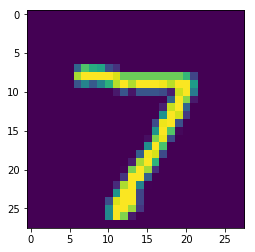

In [13]:
print('image label:', mnist_test_y[0])
plt.imshow(single_mnist_test)
plt.show()
plt.close()

In [14]:
result_in = aux_model.predict(np.reshape(single_mnist_test, (1,single_mnist_test.ravel().shape[0])))

In [15]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

max_index = [i[0] for i in enumerate(softmax(result_in[0])[0] == max(softmax(result_in[0])[0])) if i[1]]

print('The succ/failure classification:', max_index)
print('Softmax probability of in distribution:', format(result_in[1][0][0], '.2f'))

The succ/failure classification: [7]
Softmax probability of in distribution: 1.00


The above 'succ/failure classification' shows the predicted result of the input by using the model, and softmax probability indicates the possibility that the given image is in-distribution.

##### 4.2. Out Distribution Case

To create out-distribution images for testing, we bring a filter from other module and observe results by changing parameters of the filter:

In [16]:
from skimage.filters import gaussian

def add_distortion_softblur(img):
    image = img.reshape((-1, 28, 28))
    return gaussian(image, sigma=5*distortion).reshape((-1, 28*28))


We can check our results while changing parameter values for our noise function.

image label: 7


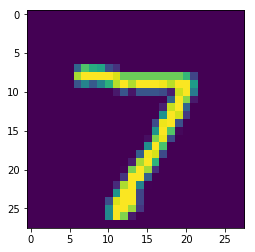

[array([[5.3739539e-12, 1.5170517e-08, 6.4742101e-11, 8.8154692e-11,
        1.1466004e-10, 1.0476074e-11, 7.9235816e-15, 1.0000000e+00,
        2.7970399e-13, 1.5669855e-08]], dtype=float32), array([[1.]], dtype=float32)]
The succ/failure classification: [7]
Softmax probability of in/out distribution: 1.00
image label: 7


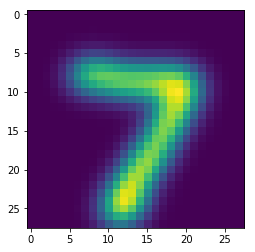

[array([[2.0786545e-05, 5.5180758e-04, 1.0636151e-04, 2.9137399e-04,
        8.6938984e-05, 4.1570176e-05, 1.5937619e-06, 9.9767345e-01,
        3.1323951e-05, 1.1947586e-03]], dtype=float32), array([[0.9998425]], dtype=float32)]
The succ/failure classification: [7]
Softmax probability of in/out distribution: 1.00
image label: 7


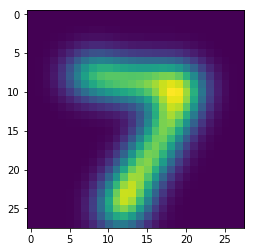

[array([[7.1424182e-04, 4.4230507e-03, 2.5249557e-03, 9.0395631e-03,
        1.4102244e-03, 1.2728804e-03, 1.0050004e-04, 9.6313196e-01,
        1.8649880e-03, 1.5517596e-02]], dtype=float32), array([[0.95863146]], dtype=float32)]
The succ/failure classification: [7]
Softmax probability of in/out distribution: 0.96
image label: 7


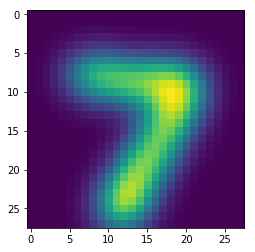

[array([[0.01480253, 0.026501  , 0.03034827, 0.10566356, 0.01589542,
        0.01847474, 0.00382224, 0.6126952 , 0.06268178, 0.10911532]],
      dtype=float32), array([[0.03011689]], dtype=float32)]
The succ/failure classification: [7]
Softmax probability of in/out distribution: 0.03
image label: 7


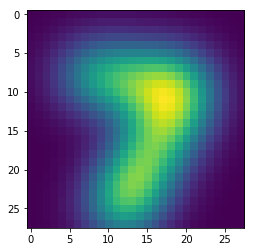

[array([[0.08264706, 0.03373931, 0.07950461, 0.0997021 , 0.04902611,
        0.04491843, 0.03902869, 0.05185422, 0.38716674, 0.13241266]],
      dtype=float32), array([[5.231585e-07]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


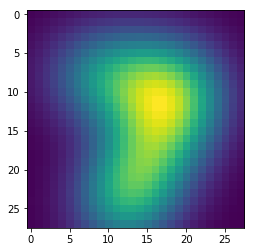

[array([[0.07924011, 0.0376715 , 0.07038539, 0.07886172, 0.05829567,
        0.05423137, 0.0580996 , 0.03799337, 0.40958184, 0.11563942]],
      dtype=float32), array([[2.1214584e-07]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


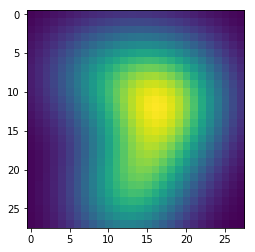

[array([[0.07243562, 0.03879851, 0.06830918, 0.07663717, 0.05810421,
        0.06049174, 0.06260972, 0.03638807, 0.42108297, 0.10514283]],
      dtype=float32), array([[1.9225917e-07]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


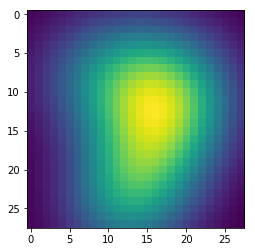

[array([[0.07082976, 0.04087324, 0.06256034, 0.07223693, 0.0620808 ,
        0.06856719, 0.07389836, 0.03543616, 0.4169193 , 0.09659784]],
      dtype=float32), array([[1.6975052e-07]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


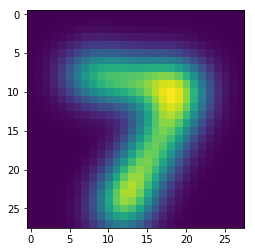

[array([[0.01915262, 0.02942235, 0.0372403 , 0.12643056, 0.0190724 ,
        0.02316352, 0.00535171, 0.5286106 , 0.08918785, 0.12236806]],
      dtype=float32), array([[0.00789543]], dtype=float32)]
The succ/failure classification: [7]
Softmax probability of in/out distribution: 0.01
image label: 7


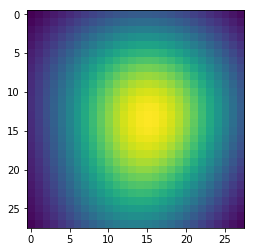

[array([[0.07986386, 0.04447575, 0.05633915, 0.06056412, 0.0680196 ,
        0.08415487, 0.10556111, 0.0320507 , 0.38979512, 0.0791757 ]],
      dtype=float32), array([[1.9396083e-07]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00


In [17]:
for i in np.arange(0, 2, 0.2):

    distortion = np.random.uniform(low=0.4, high= i)

    single_mnist_out_test = np.reshape(add_distortion_softblur(mnist_test_x[0]), (28, 28))

    ##### printing original image
    
    print('image label:', mnist_test_y[0])
    plt.imshow(single_mnist_out_test)
    plt.show()
    plt.close()

    result_out = aux_model.predict(np.reshape(single_mnist_out_test, (1,single_mnist_out_test.ravel().shape[0])))
    print(result_out)

    max_index = [i[0] for i in enumerate(softmax(result_out[0])[0] == max(softmax(result_out[0])[0])) if i[1]]

    ##### printing succ/fail classification and in/out classification probability result
    print('The succ/failure classification:', max_index)
    print('Softmax probability of in/out distribution:', format(result_out[1][0][0], '.2f'))

Although we derive a model that works in somewhat way, it is quite sensitive (The in/out probability is near either 0 or 1). In my opinion, this is also a result of high confidence issue of softmax function (which I applied at the end) mentioned in the paper. 